# Deep Learning
### Week 1: Introduction to Deep Learning

## Contents
[1. Introduction](#introduction)

[2. Machine learning recap](#ml_recap)

[3. TensorFlow Tensors and Variables (\*)](#tensors_and_variables)

[References](#references)

<a class="anchor" id="introduction"></a>
## Introduction

Welcome to the Deep Learning module! Deep learning is one of the most exciting and fastest developing areas of artificial intelligence, and continues to break new ground and set the state of the art in many application domains. In this module you will learn the foundations of deep learning and how to develop neural network architectures for different problem tasks and data domains, including design, initialisation, optimisation, prediction and evaluation. 

There will be a particular focus on practical implementation in this module, and for this you will learn the popular open source machine learning library [TensorFlow](https://www.tensorflow.org/). TensorFlow was released by Google in 2015, and is widely used today amongst researchers and professionals at all levels. 

In the later parts of the module, the focus will move towards probabilistic deep learning models, and will make use of [TensorFlow Probability](https://www.tensorflow.org/probability), which is a library that is built on top of TensorFlow that makes it easy to develop probabilistic models. 

These lecture notes are presented in jupyter notebooks to enable integration of TensorFlow code. You will see there are places where code cells are present, to demonstrate the concepts in code. In several places the code cells will be empty, and these will be for you to complete alongside the coding tutorial videos during the module. To begin, you should import TensorFlow in the cell below and check the version:

In [1]:
import tensorflow as tf
print(tf.__version__)
#git+https://github.com/bayesiains/nflows@master

2.14.0


The issue of underfitting vs overfitting is related to **model capacity**, or **model complexity**. These terms refer to the expressive power of a model, or how rich the set of patterns or relationships is that the model class is able to represent. A high capacity model is very expressive, and can represent highly sophisticated relationships in the data. The danger is that if the model capacity is too high, then it can fit spurious relationships or idiosyncrasies that are present in the training data, which aren't representative of the general properties of the data distribution, and this can lead to overfitting. Likewise, if the model capacity is too low, then the model will be unable to represent the patterns or relationships in the data, leading to underfitting.

In our running example, the kernel regressor above has high capacity, whilst the linear regressor has low capacity. 

A general schematic plot that we would expect to see is the training loss decreasing as capacity/complexity increases, whilst the test loss will decrease at first but then increase when the model becomes overly complex in relation to the data.

<img src="figures/error_vs_complexity.png" alt="Loss vs complexity" style="width: 450px;"/>
<center>Schematic diagram for error vs complexity; underfitting vs overfitting.</center>

We can see an example of this trend on our running example, if we fit a series of polynomial regressors to the training data with increasing degree. We know that the true underlying function is quadratic, so we would expect to see the test error increasing as the degree increases from 2.

This module has been put together using the latest stable release of TensorFlow at the time. 

It is likely that the APIs for TensorFlow (and other packages) may change with new version releases, and in the future some of the code presented in these notebooks and the coding tutorials may become deprecated. Make sure to keep an eye on breaking changes in newer library versions.

In this week we will review some important machine learning concepts, including a general definition of machine learning, types of problem tasks, data, and performance measures, generalisation, validation, dataset splits, overfitting/underfitting and methods of regularisation. 

We will also get started with TensorFlow by learning about two important low-level objects, which are Tensors and Variables.

<a class="anchor" id="ml_recap"></a>
## Machine learning recap

Deep learning is a subfield of machine learning, and so many of the core concepts of machine learning will be required in this module. For general machine learning references, see e.g. [Bishop](#Bishop06), [Hastie et al](#Hastie01) and [Murphy](#Murphy12). In order to motivate some of the most important concepts, let's first review the definition of machine learning itself. There are several definitions and perspectives on this, but one of the most popular is due to [Mitchell](#Mitchell97):

> A computer program is said to learn from experience E with respect to some class of tasks T and performance measure P if its performance at tasks in T, as measured by P, improves with experience E.

We can unpick this definition by looking at what is meant by _experience E, tasks T_ and _performance measure P_. 

*Tasks T.* One of the strengths of deep learning models are their flexibility to solve a wide range of problem tasks. Typical tasks could include:

* Classification
* Regression
* Clustering
* Anomaly detection
* Density estimation

*Experience E.* This relates to the type of data that is used to accomplish the given task. The data could be labelled examples (such as images of digits and their corresponding labels), unlabelled examples, or streaming data coming from an environment that an agent interacts with (this is the setting for reinforcement learning). Of course, the type of data needs to be appropriate for the learning task. A typical assumption is that the data is independent and identically distributed (iid).

*Performance measure P.* Given a learning task T and experience E, we then need a way of measuring how well a machine learning system accomplishes the task T. For example, for a regression task this could be the mean squared error, or for a binary classification task we could use binary cross entropy, or area under the ROC curve. 

For example, suppose we have a labelled dataset $\mathcal{D}:=(x_i, y_i)_{i=1}^N$ of inputs $x_i\in\mathbb{R}^D$ and outputs (or targets) $y_i\in\mathbb{R}$. The task could be a regression task, where we aim to predict a target $y$ given an input $x$, and where we measure performance using the mean squared error loss. Our aim is to minimise the expected loss under the data distribution:

$$
\begin{equation}
\mathcal{L}(\theta) := \mathbb{E}_{x, y\sim p_{data}} \left[(f_\theta(x) - y)^2\right], \tag{1}
\end{equation}
$$

where $f_\theta:\mathbb{R}^D\mapsto\mathbb{R}$ is our parameterised regression function, with parameters ${\theta}\in\mathbb{R}^p$. However, we do not have access to the true data distribution $p_{data}$, but instead only have access to the set of samples $(x_i, y_i)_{i=1}^N$.

In the following cell we create and plot a toy dataset for illustration.

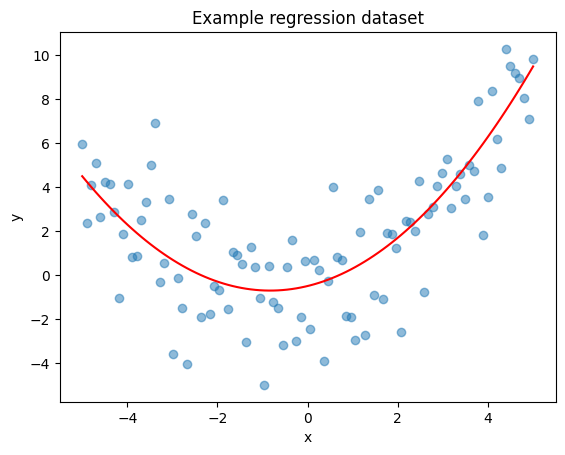

In [2]:
# Create an example toy dataset
# y = 0.3 * x**2 + 0.5 * x - 0.5 + eps,   eps ~ N(0, 4)

import numpy as np
import matplotlib.pyplot as plt

n_samples = 100
x = np.linspace(-5, 5, n_samples)[..., np.newaxis]
y_true = 0.3 * x**2 + 0.5 * x - 0.5 
noise = 2 * np.random.randn(n_samples, 1)
y = y_true + noise

plt.plot(x, y_true, 'r-')
plt.scatter(x, y, alpha=0.5)
plt.title("Example regression dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

#### Data splits
In order to obtain a fair measure of the performance of an ML model, we typically split our available data into training and test partitions. The training data is used to infer the optimal parameters of our model, whilst the test data is used purely for evaluation. In addition, a third partition for validation data is also often used to tune the hyperparameters of the model. You should never use the validation or test splits for directly training the model (optimising its parameters).

In the following cell we use `sklearn` to make a training and test partition of our toy dataset.

In [3]:
# We can use the train_test_split from sklearn to conveniently split the data

from sklearn.model_selection import train_test_split

print("x shape:", x.shape)
print("y shape:", x.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)
print("\nx_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("\nx_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x shape: (100, 1)
y shape: (100, 1)

x_train shape: (60, 1)
y_train shape: (60, 1)

x_test shape: (40, 1)
y_test shape: (40, 1)


This means that in practice what we optimise during training is the loss

$$
\begin{equation}
L(\theta) = \frac{1}{| \mathcal{D}_{train} |}\sum_{x_i, y_i\in \mathcal{D}_{train}}(f_\theta(x_i) - y_i)^2, \tag{2}
\end{equation}
$$

where $\mathcal{D}_{train}$ denotes the training data partition.

The following cells illustrate this for our toy dataset, by creating an example regression function and computing the training loss using the inbuilt function from TensorFlow.

In [4]:
# Define an example regression function

def example_f(x_):
    return 0.5 * x_**2 + 0.9 * x_ - 0.25

In [5]:
# Evaluate the MSE on the training set using TensorFlow MSE function

def mse(y_pred, y_true):
    return tf.reduce_mean(tf.keras.losses.mse(y_pred, y_true))

train_loss = mse(example_f(x_train), y_train)
print("Training loss: {:.4f}".format(train_loss))

Training loss: 10.5752


In [6]:
# Check the tf.keras function is doing what we expect

np.allclose(mse(example_f(x_train), y_train), np.mean((example_f(x_train) - y_train)**2))

True

Usually, the bulk of the available data would be used for training. A typical split might be something like 60/20/20 for training/validation/test. In any case, it is important that the validation and test sets are large enough to be a representative sample of the data. They are both used as proxies for new data that could be presented to the model in deployment, and so give a measure of how well the model generalises to unseen data. 

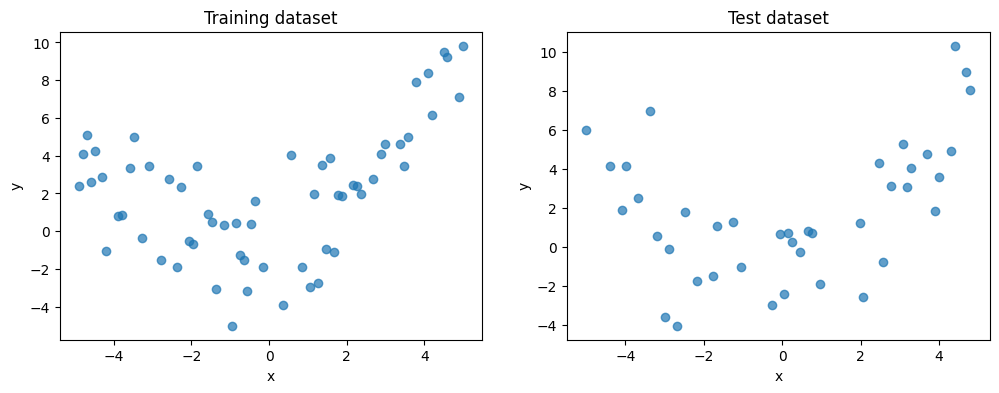

In [7]:
# View the training and test data

fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
plt.scatter(x_train, y_train, alpha=0.7)
plt.title("Training dataset")
plt.xlabel("x")
plt.ylabel("y")

fig.add_subplot(1, 2, 2)
plt.scatter(x_test, y_test, alpha=0.7)
plt.title("Test dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

#### Overfitting and underfitting

A common issue in all machine learning models is underfitting vs overfitting. Overfitting is when a model becomes too specific to the training data, and doesn't generalise well beyond it. It is characterised by having a good performance measure on the training data and much worse performance on the test data. Underfitting is just the reverse; it is where a model does not manage to fit the training (or test) data well. It is characterised by a similar poor performance on both training and test sets.

The following cells show examples of this using our toy dataset and regression functions from `sklearn`.

In [8]:
# Fit a kernel regressor to the training data

from sklearn.kernel_ridge import KernelRidge

kernel_regressor = KernelRidge(alpha=1e-5, kernel='rbf', gamma=1.)
kernel_regressor.fit(x_train, y_train)

kernel_train_loss = mse(kernel_regressor.predict(x_train), y_train)
kernel_test_loss = mse(kernel_regressor.predict(x_test), y_test)

In [9]:
# Fit a high-degree polynomial and a linear model to the training data

from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
linear_regressor.fit(x_train, y_train)

linear_train_loss = mse(linear_regressor.predict(x_train), y_train)
linear_test_loss = mse(linear_regressor.predict(x_test), y_test)

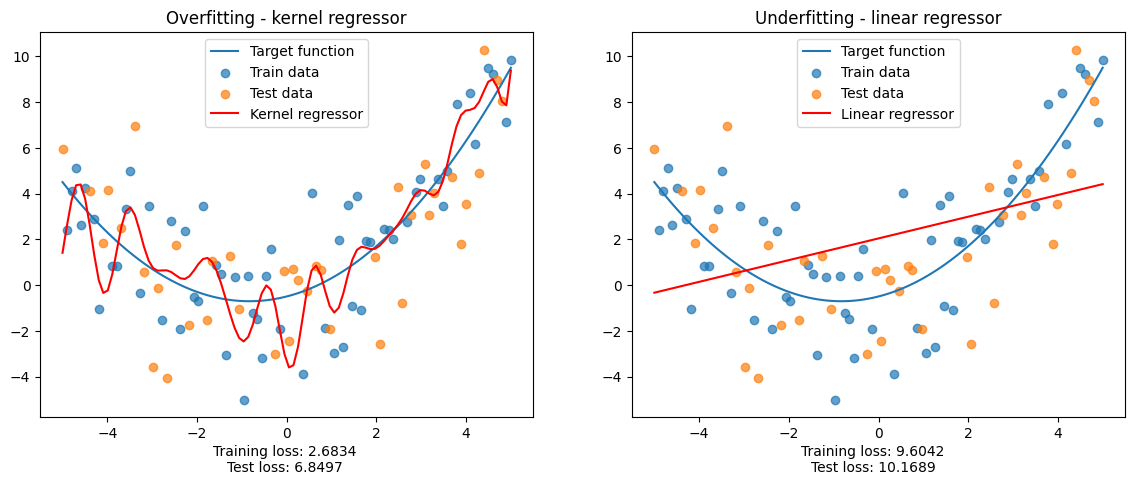

In [10]:
# View the training and test data

fig = plt.figure(figsize=(14, 5))
fig.add_subplot(1, 2, 1)
plt.plot(x, y_true, label="Target function")
plt.scatter(x_train, y_train, alpha=0.7, label='Train data')
plt.scatter(x_test, y_test, alpha=0.7, label='Test data')

plt.plot(x, kernel_regressor.predict(x), 'r-', label="Kernel regressor")
plt.title("Overfitting - kernel regressor")
fig.text(0.3, 0., "Training loss: {:.4f}\nTest loss: {:.4f}".format(kernel_train_loss, kernel_test_loss),
        ha='center')
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot(x, y_true, label="Target function")
plt.scatter(x_train, y_train, alpha=0.7, label='Train data')
plt.scatter(x_test, y_test, alpha=0.7, label='Test data')

plt.plot(x, linear_regressor.predict(x), 'r-', label="Linear regressor")
plt.title("Underfitting - linear regressor")
fig.text(0.72, 0., "Training loss: {:.4f}\nTest loss: {:.4f}".format(linear_train_loss, linear_test_loss),
        ha='center')
plt.legend()
plt.show()

The issue of underfitting vs overfitting is related to **model capacity**, or **model complexity**. These terms refer to the expressive power of a model, or how rich the set of patterns or relationships is that the model class is able to represent. A high capacity model is very expressive, and can represent highly sophisticated relationships in the data. The danger is that if the model capacity is too high, then it can fit spurious relationships or idiosyncrasies that are present in the training data, which aren't representative of the general properties of the data distribution, and this can lead to overfitting. Likewise, if the model capacity is too low, then the model will be unable to represent the patterns or relationships in the data, leading to underfitting.

In our running example, the kernel regressor above has high capacity, whilst the linear regressor has low capacity. 

A general schematic plot that we would expect to see is the training loss decreasing as capacity/complexity increases, whilst the test loss will decrease at first but then increase when the model becomes overly complex in relation to the data.

<img src="figures/error_vs_complexity.png" alt="Loss vs complexity" style="width: 450px;"/>
<center>Schematic diagram for error vs complexity; underfitting vs overfitting.</center>

We can see an example of this trend on our running example, if we fit a series of polynomial regressors to the training data with increasing degree. We know that the true underlying function is quadratic, so we would expect to see the test error increasing as the degree increases from 2.

In [11]:
# Fit polynomial regressors for different degrees

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

num_degrees = 20
degrees = np.arange(num_degrees)

polynomial_regressors = []
for degree in degrees:
    poly_regressor = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_regressor.fit(x_train, y_train)
    polynomial_regressors.append(poly_regressor)

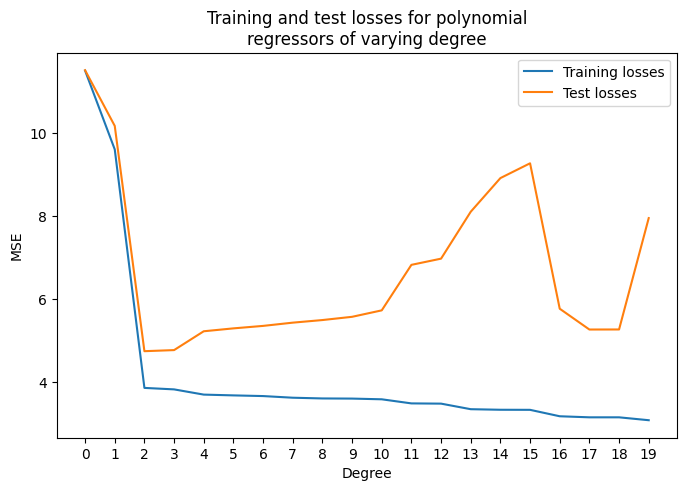

In [12]:
# Plot the training and test losses for the polynomial regressors

train_losses = [mse(pr.predict(x_train), y_train) for pr in polynomial_regressors]
test_losses = [mse(pr.predict(x_test), y_test) for pr in polynomial_regressors]

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training losses')
plt.plot(test_losses, label='Test losses')
plt.title("Training and test losses for polynomial\nregressors of varying degree")
plt.xticks(np.arange(num_degrees))
plt.xlabel("Degree")
plt.ylabel("MSE")
plt.legend()
plt.show()

Note that if we used the above information to select the best hyperparameter (polynomial degree), then we would in fact be using the data split as a training/validation split, and so should use a separate test set for a final evaluation of the model.

#### Loss functions

The parameters of deep learning models are often optimised using maximum likelihood estimation. That is, we search for parameters $\hat\theta$ such that

$$
\hat\theta = \underset{\theta}{\arg \max} ~\mathbb{P}_{model}(\mathcal{D}_{train}; \theta).
$$

Many common loss functions can be derived through the principle of maximum likelihood and certain modelling assumptions. For example, the mean squared error loss function above (2) can be derived as the negative log-likelihood of the training data under the assumption of homoscedastic Gaussian observation noise (up to a constant scaling factor). 

Similarly, cross entropy loss functions arise in classification problems when applying the principle of maximum likelihood. In a supervised classification problem where there are $C$ classes, and we have a parameterised model $f_{\theta}:\mathbb{R}^D\mapsto[0, 1]^C$ whose output can be interpreted as a categorical distribution over $C$ classes, then the categorical cross entropy loss function is given by

$$
L(\theta) = -\frac{1}{|\mathcal{D}_{train}|} \sum_{x_i, \tilde{y}_{i}\in\mathcal{D}_{train}}\sum_{j=1}^{C} \tilde{y}_{ij} \ln f_\theta(x_i)_j,
$$

where $\tilde{y}_{ij}$ is the binary label for example $i$, that is equal to 1 if the correct class is $C_j$, and 0 otherwise.

In the particular case of binary classification we obtain

$$
L(\theta) = -\frac{1}{|\mathcal{D}_{train}|} \sum_{x_i, y_i\in\mathcal{D}_{train}} {y}_{i} \ln f_\theta(x_i) + (1-{y}_{i}) \ln (1 - f_\theta(x_i)),
$$

where in the above, the labels $y_i \in\{0, 1\}$, $f_{\theta}:\mathbb{R}^D\mapsto[0, 1]$, and the model output is interpreted as the probability that the input $x_i$ belongs to class 1.

#### Regularisation

A common way to tackle problems of overfitting is through regularisation methods. Broadly speaking, methods of regularisation seek to constrain the model capacity. There are many methods of regularisation depending on the model, data and task. Some examples of regularisation techniques that are used for deep learning models are:

* Weight decay
* Patience/early stopping
* Control model complexity
* Dropout
* Weight sharing
* Dataset augmentation

We will be using several of these regularisation techniques in implementations during the module. The last of these - dataset augmentation - is worth singling out as the best form of regularisation if it is possible.

For example, for a linear model of the form

$$
f(\mathbf{x}) = \sum_j w_j \phi_j(\mathbf{x})
$$

a typical regularisation is to add a sum of squares penalty term to discourage the weights $w_j$ from getting too large. Specifically, instead of minimising the mean squared error (2), we minimise the loss function

$$
\begin{equation}
L(\mathbf{w}, \alpha) = \frac{1}{| \mathcal{D}_{train} |}\left(\sum_{x_i, y_i\in \mathcal{D}_{train}}(f(x_i) - y_i)^2 
+ \alpha\sum_j w_j^2\right), \tag{3}
\end{equation}
$$

where the coefficient $\alpha$ is a hyperparameter.

<a class="anchor" id="tensors_and_variables"></a>
## TensorFlow Tensors and Variables

In this section we will introduce some fundamental building blocks and operations in TensorFlow. [Tensors](https://www.tensorflow.org/api_docs/python/tf/Tensor) and [Variables](https://www.tensorflow.org/api_docs/python/tf/Variable) are low-level objects that we will be using all the time in TensorFlow.

#### Tensors
You can think of Tensors as being multidimensional versions of vectors and arrays. Of course, these are the objects that TensorFlow gets its name from. When we build our neural network models, what we’re doing is defining a computational graph, where input data is processed through the layers of the network and sent through the graph all the way to the outputs. Tensors are the objects that get passed around within the graph, and capture those computations within the graph. 

Let’s take a look at some examples to get a better feel for how this works.

In [13]:
import tensorflow as tf

In [14]:
# Create a constant Tensor

a = tf.constant([1, 2, 3])
print(a)

tf.Tensor([1 2 3], shape=(3,), dtype=int32)


We can see that Tensors have `shape` and `dtype` properties, similar to NumPy arrays.

In [15]:
# Examine shape property

a.shape

TensorShape([3])

In [16]:
# Examine dtype property

a.dtype

tf.int32

Tensor objects can have different types, just like NumPy arrays. Take a look [here](https://www.tensorflow.org/api_docs/python/tf#other-members_1) for a complete list of available types.

In [17]:
# Create Tensor objects of different type

string_tensor = tf.constant(["Hello world!"], tf.string)
float_tensor  = tf.constant([3.14159, 2.71828], tf.float32)
print(string_tensor)
print(float_tensor)

tf.Tensor([b'Hello world!'], shape=(1,), dtype=string)
tf.Tensor([3.14159 2.71828], shape=(2,), dtype=float32)


In [18]:
# Create a rank-2 Tensor 

b = tf.constant([[1.2, 0.4, 0.7], [-9.3, 4.5, 1.1]])
b

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.2,  0.4,  0.7],
       [-9.3,  4.5,  1.1]], dtype=float32)>

In [19]:
# Get Tensor rank

tf.rank(b)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [20]:
# Create a Tensor with tf.ones

tf.ones((2, 3))

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)>

In [21]:
# Create a Tensor with tf.zeros

tf.zeros((3,))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>

We can convert a TensorFlow Tensor into a NumPy array using the `numpy` method.

In [22]:
# Convert Tensor to NumPy array

b_np = b.numpy()
print(type(b_np))
b_np

<class 'numpy.ndarray'>


array([[ 1.2,  0.4,  0.7],
       [-9.3,  4.5,  1.1]], dtype=float32)

We can compute Tensor multiplication using `tf.tensordot` (see the [docs](https://www.tensorflow.org/api_docs/python/tf/tensordot)). The `axes` argument can be an integer or list of integers. When it is a single integer `n`, the contraction is performed over the last `n` axes of the first Tensor and the first `n` axes of the second Tensor. If it is a list, then the elements of the list specify the axes to contract.

In [23]:
# Compute matrix-vector product

# tf.tensordot(b, a, axes=1)  # Type error

a = tf.cast(a, tf.float32)
tf.tensordot(b, a, axes=1)  # Sum over last axis of b and first axis of a
tf.tensordot(b, a, axes=[[1], [0]])  # Equivalent

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.1, 3. ], dtype=float32)>

In the case of two rank-2 Tensors, we can use the `tf.linalg.matmul` function. (In fact, we can use rank >= 2 Tensors with `tf.linalg.matmul` - see the [docs](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul).) 

In [24]:
# Use tf.linalg.matmul to compute product

# tf.linalg.matmul(b, a)  # Shape error

print(b.shape)
print(a.shape)

(2, 3)
(3,)


Useful operations to manipulate Tensor shapes are `tf.expand_dims`, `tf.squeeze` and `tf.reshape`.

In [25]:
# Add an extra dimension to a Tensor

a = tf.expand_dims(a, 1)
print(a.shape)

(3, 1)


In [26]:
# Use tf.linalg.matmul, tf.squeeze and tf.reshape

# tf.linalg.matmul(b, a)
tf.reshape(tf.squeeze(tf.linalg.matmul(b, a)), [1, 2])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[4.1, 3. ]], dtype=float32)>

It is also often useful to fill Tensors with random values.

In [27]:
# Create a random normal Tensor

tf.random.normal((3, 3))

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.16414489,  1.3994274 , -0.6529903 ],
       [-0.35996807,  1.2841387 ,  1.2709677 ],
       [ 2.0761323 , -0.8072799 ,  0.15665068]], dtype=float32)>

In [28]:
# Create a random integer Tensor

tf.random.uniform(shape=(2, 4), minval=0, maxval=10, dtype='int32')

<tf.Tensor: shape=(2, 4), dtype=int32, numpy=
array([[1, 0, 4, 6],
       [6, 8, 5, 0]], dtype=int32)>

#### Variables
Tensors are *immutable objects*; that is, their state cannot be modified. The operations they encapsulate (or the values of a constant Tensor) are fixed. Variables are special kinds of Tensors that have *mutable state*, so their values can be updated. This is useful for parameters of a model, such as the weights and biases in a neural network.

In [29]:
# Create a TensorFlow Variable

initial_value = tf.random.normal((2, 2))
u = tf.Variable(initial_value)
u

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-1.1943045, -0.3068129],
       [-1.2942394, -1.0497476]], dtype=float32)>

This looks very similar to a Tensor. However, Variables come with extra methods for updating their state, such as `assign`, `assign_add` and `assign_sub`.

In [30]:
# Assign a new value to the Variable

new_value = 2. * tf.ones((2, 2))
u.assign(new_value)
u

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>

In [31]:
# Add a value to the Variable

increment = tf.constant([[0., 0.], [1., 1.]])
u.assign_add(increment)
u

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[2., 2.],
       [3., 3.]], dtype=float32)>

In [32]:
# Subtract a value from the Variable

decrement = tf.constant([[2., 0.], [2., 0.]])
u.assign_sub(decrement)
u

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0., 2.],
       [1., 3.]], dtype=float32)>

We will often use Variables in operations within the computational graph. The result of the operation is a Tensor.

In [33]:
# Use a Variable in a simple operation

v = tf.Variable([2.6, -0.4])
s = v + 1
s

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([3.6, 0.6], dtype=float32)>

<a class="anchor" id="references"></a>
### References

<a class="anchor" id="Bishop06"></a>
* Bishop, C. M. (2006), "Pattern Recognition and Machine Learning", Springer-Verlag, Berlin, Heidelberg.
<a class="anchor" id="Clevert16"></a>
* Clevert, D.-A., Unterthiner, T., & Hochreiter, S. (2016), "Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUs)", in *4th International Conference on Learning Representations, {ICLR} 2016", San Juan, Puerto Rico, May 2-4, 2016.
<a class="anchor" id="Hastie01"></a>
* Hastie, T., Tibshirani, R. & Friedman, J. (2001), "The Elements of Statistical Learning", Springer New York Inc., New York, NY, USA.
<a class="anchor" id="Klambauer17"></a>
* Klambauer, G., Unterthiner, T., Mayr, A., & Hochreiter, S. (2017), "Self-Normalizing Neural Networks", *Neural Information Processing Systems (NIPS)*, 971-980.
<a class="anchor" id="McCullochPitts43"></a>
* McCulloch, W. & Pitts, W. (1943), "A Logical Calculus of Ideas Immanent in Nervous Activity", Bulletin of Mathematical Biophysics, **5**, 127-147. 
<a class="anchor" id="Mitchell97"></a>
* Mitchell, T. (1997), "Machine Learning", McGraw-Hill, New York.
<a class="anchor" id="Murphy12"></a>
* Murphy, K. P. (2012), "Machine Learning: A Probabilistic Perspective", The MIT Press.
<a class="anchor" id="Ramachandran18"></a>
* Ramachandran, P., Zoph, B. & Le, Q. V. (2018) "Searching for Activation Functions", arXiv preprint, abs/1710.05941.
<a class="anchor" id="Rosenblatt58"></a>
* Rosenblatt, F. (1958), "The Perceptron: A Probabilistic Model for Information Storage and Organization in The Brain", Psychological Review, 65-386.
<a class="anchor" id="Rosenblatt61"></a>
* Rosenblatt, F. (1961), "Principles of Neurodynamics. Perceptrons and the Theory of Brain Mechanisms", Defense Technical Information Center.